<img src="../../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Exercise 2.4 - And now, for our feature presentation...</h1>
<h2 align="center"> Extracting features from a continuous movie stimulus to build a model</h2> 
<h2 align="center">Summer Workshop on the Dynamic Brain</h2> 

<div class="alert alert-block alert-success">

In the workshops and other exercises we looked at the responses of neurons to brief visual stimuli (250ms flashes). Unless you are at club with with an intense strobe light, this is far from the usual visual experience. Visual scenes have movement and evolve continuously. The visual coding and visual behavior datasets include 10 repeated presentations of 30 second clips from a movie (Touch of Evil, 1958, Orson Welles) to achieve a more natural visual input. 

This type of stimulus contains more rich information than static presentations. Each frame may have different image statistics and types of objects and there relationship between the contents of each frame. 

**How do we extract meaningful information from continuous stimuli to build a model that includes information the visual system may care about?**

In this exercise we will:
1) Get neural activity (visual behavior ophys) related to the movie stimulus
2) Use an approach called feature engineering to extract meaningful information from the movie
3) Build a model to predict single cell activity from the movie features, using leave one out cross-validation

For more information about the movie, see here:
+ https://observatory.brain-map.org/visualcoding/stimulus/natural_movies
+ https://allensdk.readthedocs.io/en/latest/visual_behavior_optical_physiology.html#behavioral-training

In [10]:
# import basics 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy.signal as signal
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

# import allensdk 
import allensdk
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache
allensdk.__version__

# import utilities to reformat neural activity data
import brain_observatory_utilities.datasets.optical_physiology.data_formatting as data_formatting
import brain_observatory_utilities.utilities.general_utilities as general_utilities

# import scikit-learn functions for the model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

In [11]:
# Find some data!
import platform
platstring = platform.platform()

if 'Darwin' in platstring:
    # macOS 
    data_root = "/Volumes/Brain2024/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on CodeOcean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2024/"

<div class="alert alert-block alert-success">

<h4>0) Get the movie and a dataset of neural responses</h4>

First load the movie

In [12]:
# Method 1: The movie stimulus is attached to every visual coding dataset. Lets grab a random session and get the movie stimulus.
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
manifest_file = os.path.join(data_root,'allen-brain-observatory/visual-coding-2p/manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_file)
session_id = 508356957 # random session id
session_data = boc.get_ophys_experiment_data(session_id)
movie = session_data.get_stimulus_template(stimulus_name='natural_movie_one')
print(f"Movie shape: {movie.shape}")

Movie shape: (900, 304, 608)


In [13]:
# Method 2: provide direct path to the movie stimulus
# movie_path = r"/allen/programs/braintv/workgroups/neuralcoding/Saskia/Visual Stimuli 151207/Movie_TOE1.npy"  # CHANGE TO YOUR PATH
# movie = np.load(movie_path)
# print(f"Movie shape: {movie.shape}")

Plot every 100 frames of the movie

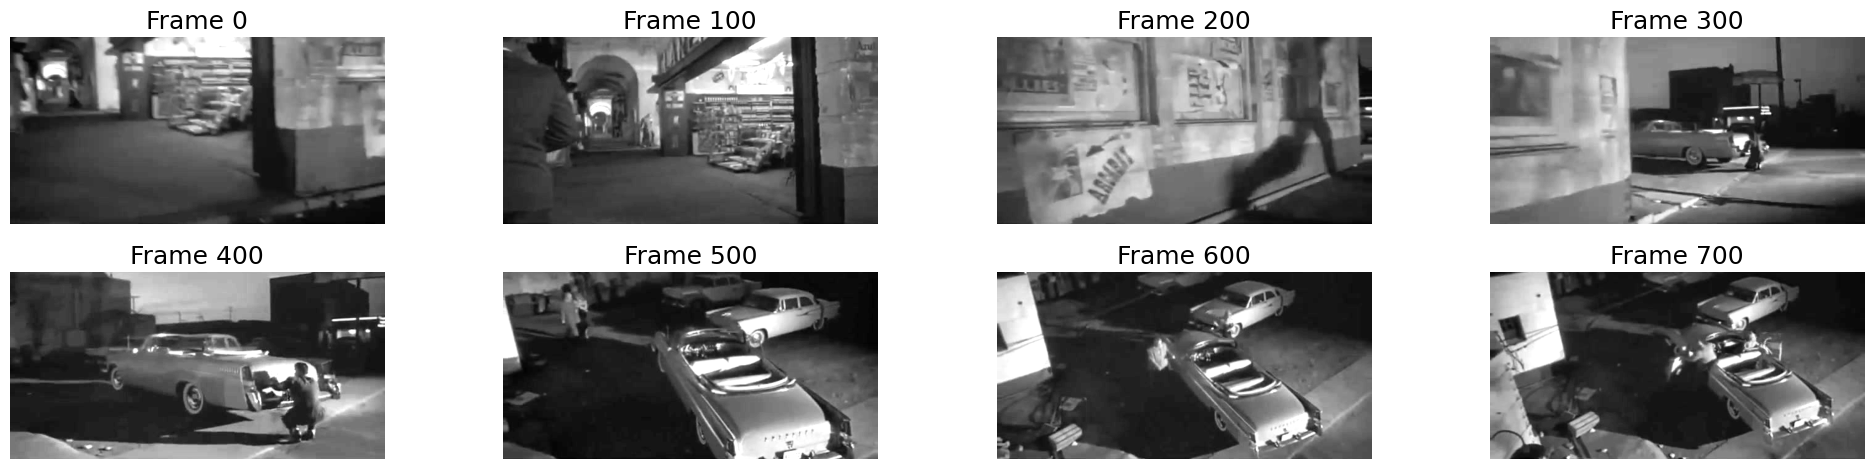

In [14]:
fig, ax = plt.subplots(2,4,figsize=(20, 5))
ax = ax.ravel()
for i in range(8):
    ax[i].imshow(movie[100*i], cmap='gray')
    ax[i].set_title(f"Frame {100*i}")
    ax[i].axis('off')
plt.tight_layout()

Get some neural data from visual behavior ophys

In [15]:
# supress warnings
import warnings
warnings.filterwarnings('ignore')

output_dir = r'/swdb2024_data_cache'
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=output_dir)

behavior_session_table = cache.get_behavior_session_table()  
ophys_session_table = cache.get_ophys_session_table()   
ophys_experiment_table = cache.get_ophys_experiment_table()    
ophys_cells_table = cache.get_ophys_cells_table()

project_code = 'VisualBehaviorMultiscope'
multiscope_sessions = ophys_session_table[ophys_session_table.project_code==project_code]

print(f"Number of mice: {len(multiscope_sessions.mouse_id.unique())}")
print(multiscope_sessions.full_genotype.unique())

# pick a mouse + a sessions from visual behavior that have movie stimulus at the end
mouse_id = '546605' # SST
sessions = ophys_session_table[(ophys_session_table.mouse_id==mouse_id) & 
                                (ophys_session_table.session_type=='OPHYS_1_images_A')]

# get the dataset for an experiment
ophys_experiment_id = 1080945462
dataset = cache.get_behavior_ophys_experiment(ophys_experiment_id)

Number of mice: 24
['Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt'
 'Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt'
 'Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt']


<div class="alert alert-block alert-success">
<h4>1) Getting movie related neural activity</h4>

<div class="alert alert-block alert-success">

**(1a) Get movie related stimulus blocks from stimulus_presentations**

+ Make new table, movie_presentations, with just "natural_movie_one" stimuli.
+ How many movie_repeats are there? 
+ How many frames in one repeat of the movie?


<div class="alert alert-block alert-success">

**Optional:** calculate the frame rate of the movie from the 'duration' columns


So we have around 30hz x 900 frames = 30 second movie

<div class="alert alert-block alert-success">

**(1b) Get the start times of each movie**

call this variable 'event_times'

<div class="alert alert-block alert-success">

**(1c) Get neural activity aligned to movie start times**

Use:
+ `brain_observatory_utilities.datasets.optical_physiology.data_formatting.build_tidy_cell_df` to format neural data in convient way
+ `brain_observatory_utilities.utilities.general_utilities.event_triggered_response` to align any list of event_times/start_times with neural data
+ Note: you can study how get_stimulus_response_df() calls the more specific function event_triggered_response(), but don't spend too much time on this step. The particulars can be
found in the solutions notebook.


Get the data with data_formatting.build_tidy_cell_df

Here we gave the set up for getting the event_triggered response for the all the cells. Just fill in the main function 

In [24]:
output_sampling_rate = 30 # hz
time_window = [0, 30] # large time window to capture the whole movie
interpolate = True
data_type = 'dff'

# collect aligned data
sliced_dataout = []

# align data using interpolation method
for unique_id in unique_cell_ids:
    # FILL THIS IN
    etr = ???

    # get timestamps array
    trace_timebase = etr.index.values

    # collect aligned data from all cell, all trials into one array
    sliced_dataout.append(etr.transpose().values)
sliced_dataout = np.array(sliced_dataout)

# remove the last element of the timebase array and the last element of the data array
trace_timebase = trace_timebase[:-1]
sliced_dataout = sliced_dataout[:, :, :-1]

print(sliced_dataout.shape)

(5, 10, 900)


<div class="alert alert-block alert-success">

**(1d) Plot the activity of each repeat for one cell. Plot the mean across repeats**

<div class="alert alert-block alert-success">

**(1e) Plot the mean response (to all repeats) of each cell**

<div class="alert alert-block alert-success">

<h4>2) Extract features from the movie</h4>

Here we extract a set of features to use in our model. The following paper used a similar approach,
so lets take inspiration from the authors for which features to extract.

Froudarakis 2014 "Population code in mouse V1 facilitates readout of 
natural scenes through increased sparseness".

<div class="alert alert-block alert-success">

**(2a) Calculate the features**


For each frame calculate:
1) Average pixel intensity
2) Kurtosis of pixel intensities
3) Contrast (standard deviation) of pixel intensities
4) Motion energy between frames (how much the movie changes frame to frame); a higher number indicates more "motion" between frames

Motion energy function given for free

In [27]:
# function to calculate the "motion energy" between frames
def calc_motion_energy(movie: np.array) -> np.array:
    """
    Calculate motion energy between frames,
    defined as the sum of absolute differences between frames

    Parameters
    ----------
    movie : np.array
        The movie to calculate motion energy for

    Returns
    -------
    motion_energy : np.array
        The motion energy between
    """
    # calculate motion energy
    motion_energy = np.zeros(movie.shape[0]-1)
    for i in range(movie.shape[0]-1):
        motion_energy[i] = np.sum(np.abs(movie[i+1] - movie[i]))

    # add zero to the end
    motion_energy = np.append(motion_energy, 0)
    return motion_energy

Fill in the other metrics

In [28]:
# calculate motion energy between frames
def calc_movie_metrics(movie):
    """Calculate motion energy, average, contrast, and kurtosis for a movie"""

    # calculate motion energy
    motion_energy = calc_motion_energy(movie)
    avg = ???
    contrast = ???
    kurtosis = ???

    return motion_energy, avg, contrast, kurtosis

motion_energy, avg, contrast, kurtosis = calc_movie_metrics(movie)

<div class="alert alert-block alert-success">

**(2b) Filter motion energy and plot**
<p>
Plot the motion energy, notice something strange? It dips near zero every few frames, because nearly identical frames appear every so often. This is do to some resampling strategy used to generate the movie stimulus.
Is it fair to assume the mouse visual system would not detect the identical frames? For this exercise lets assume yes, and smooth out the motion energy.

Use scipy.signal.medfilt to smooth the motion energy

<div class="alert alert-block alert-success">

**(2c) Plot all 4 features on subplots. Add the mean response for a single cell.**

<div class="alert alert-block alert-success">
<h4>3) Build a linear model using extracted features</h4>

<div class="alert alert-block alert-success">

**(3a) Create stimulus matrix X with 4 features. Use MinMaxScaler() to normalize.**

In [31]:
X = np.vstack([????]).T # start here

<div class="alert alert-block alert-success">

**(3b) Create a linear regression model using stimulus features X to predict neural response y**
+ The movie is presented 10 times and we have the nueral repsponses to each of those repeats
+ To train the model using all the repeats, we just need to alter the shapes inputs X and Y.
+ We can stack the response of one cell to each repeat into a long vector, and use that as the response vector Y.
+ We need to duplicate the X stimlus matrix to match the 1st dimension of the Y vector (use np.tile)
+ Use LeaveOneOut() cross-validation in a for loop. In every loop leave out one of the movie repeats. Therefore there will be 10 different models,
with a different repeat left out each time.
+ Use the mean_square_error metric to evaulate model performance
+ Try different cells. Does the MSE change? How do the predictions compare?
+ Are these models useful? What would happen if we just used a baseline model (e.g. predicted the mean) the whole time? What is the MSE then?

In [33]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error

# first select all the repeats for a single cell
CELL_INDEX = 2
cell_dff_repeats = sliced_dataout[CELL_INDEX]
print(cell_dff_repeats.shape)

<div class="alert alert-block alert-success">

**(3c) create average model**
<p>
Use the coefficients and intercepts list to create a new linear model (average model)

<div class="alert alert-block alert-success">

**Bonus 1a: use polynomial features in a linear model to improve predictions**

We can create even more features with this strategy that accounts for combinations of interactions between the features.
The number of features created is controlled by degree parameter. Be careful, it too high can lead to overfitting.

In [39]:
from sklearn.preprocessing import PolynomialFeatures

degree = 2 # select a sensible degree for polynomial features.
movie_features = X
poly = PolynomialFeatures(degree)
movie_features_poly = poly.fit_transform(movie_features)

In [ ]:
# create model with LOO cross-validation

<div class="alert alert-block alert-success">

**Bonus 1b: create average model**
<p>
Use the coefficients and intercepts list to create a new linear model (average model)

<div class="alert alert-block alert-success">

**Bonus 1c: Plot predictions for 2 models along with true activity for a cell**
+ True
+ Predicted activity (linear)
+ Predicted activity (polynomial)

<div class="alert alert-block alert-success">

**Bonus 2: Does cropping the movie lead to better model?**

Maybe certain neurons are more sensitive to features in the center of the screen?

<div class="alert alert-block alert-success">

In this exercise we introdiced the movie stimulus, practiced getting neural activity aligned to any stimulus start_time, and extracted features to build regression models. We built a simple model using LeaveOneOut crossvalidation.  This is just the start, what else can we discover using the movie stimulus?
+ More sophisticated feature extraction methods (e.g. neural networks)
+ Non linear modeling
+ Different cell types (VIP, SST, PV, excitatory). Perhaps others or more/less sensitive to movies?
+ How can one incorporate information about a neurons receptive fields?